In [1]:
## Scitific Computing with Python
import pandas as pd
import numpy as np

## Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

## File dirtectory
import os

Matplotlib is building the font cache; this may take a moment.


# 1. Import Data

In [ ]:
## Modifiable data path
workingDir = os.getcwd()
hrsFullPath = os.path.join(workingDir, 'Data', 'randhrs1992_2022v1.sas7bdat')
hrsSuppPath = os.path.join(workingDir, 'Data', 'sasfmts.sas7bdat')

## Due to big file size, only select the first 10000 rows as the sample for EDA
hrsFull = pd.read_sas(hrsFullPath, chunksize=10000)
hrsSupp = pd.read_sas(hrsSuppPath)

In [4]:
## Get only thef first chunk of the data for EDA
hrsFull = next(hrsFull)

In [5]:
print(hrsFull.shape)
print(hrsSupp.shape)

(10000, 19880)
(8632, 21)


In [5]:
print(hrsSupp.columns)

Index(['FMTNAME', 'START', 'END', 'LABEL', 'MIN', 'MAX', 'DEFAULT', 'LENGTH',
       'FUZZ', 'PREFIX', 'MULT', 'FILL', 'NOEDIT', 'TYPE', 'SEXCL', 'EEXCL',
       'HLO', 'DECSEP', 'DIG3SEP', 'DATATYPE', 'LANGUAGE'],
      dtype='object')


In [6]:
hrsSupp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8632 entries, 0 to 8631
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FMTNAME   8632 non-null   object 
 1   START     8632 non-null   object 
 2   END       8632 non-null   object 
 3   LABEL     8632 non-null   object 
 4   MIN       8632 non-null   float64
 5   MAX       8632 non-null   float64
 6   DEFAULT   8632 non-null   float64
 7   LENGTH    8632 non-null   float64
 8   FUZZ      8632 non-null   float64
 9   PREFIX    0 non-null      object 
 10  MULT      8632 non-null   float64
 11  FILL      0 non-null      object 
 12  NOEDIT    8632 non-null   float64
 13  TYPE      8632 non-null   object 
 14  SEXCL     8632 non-null   object 
 15  EEXCL     8632 non-null   object 
 16  HLO       58 non-null     object 
 17  DECSEP    0 non-null      object 
 18  DIG3SEP   0 non-null      object 
 19  DATATYPE  0 non-null      object 
 20  LANGUAGE  0 non-null      obje

In [14]:
hrsSupp.describe()

,MIN,MAX,DEFAULT,LENGTH,FUZZ,MULT,NOEDIT
count,8632.0,8632.000000,8632.000000,8632.000000,8.632000e+03,8632.0,8632.0
mean,1.0,40.314296,15.571478,15.571478,9.991891e-13,0.0,0.0
std,0.0,2.228680,12.845372,12.845372,2.846704e-14,0.0,0.0
min,1.0,40.000000,2.000000,2.000000,0.000000e+00,0.0,0.0
25%,1.0,40.000000,6.000000,6.000000,1.000000e-12,0.0,0.0
50%,1.0,40.000000,6.000000,6.000000,1.000000e-12,0.0,0.0
75%,1.0,40.000000,25.000000,25.000000,1.000000e-12,0.0,0.0
max,1.0,73.000000,73.000000,73.000000,1.000000e-12,0.0,0.0


# 2. How is an observation identified?

In [32]:
# How many participants are there?
person_id = ["HHIDPN", "HHID", "PN", "RAHHIDPN"]
print(hrsFull[person_id].head())
print(f'There are {len(hrsFull["RAHHIDPN"].unique())} people')

       HHIDPN       HHID      PN      RAHHIDPN
0      1010.0  b'000001'  b'010'  b'000001010'
1      2010.0  b'000002'  b'010'  b'000002010'
2      3010.0  b'000003'  b'010'  b'000003010'
3      3020.0  b'000003'  b'020'  b'000003020'
4  10001010.0  b'010001'  b'010'  b'010001010'
There are 10000 people


The unit of observation is an individual. An individual is identified by a household ID (HHID) and a person ID (PN), HHIDPN is the two merged by 1000*HHID + PN. In particular, HHID is a 6-digit string, and PN is a 3-digit string.

It shows that there are 10 K distinct people in the selected chunk, which measn that there is no repeated measurement in the selected chunk.

The complete data set consists of 45234 people, contributing ### rows.

In [33]:
## How many different households have been surveyed?
print(f'There are {len(hrsFull["HHID"].unique())} households')

There are 5569 households


There are 16 waves of participants with each wave assigned with sub-households numbers.

In [ ]:
## What are waves status of participants who responded come from?
for i in range(1, 17):
    print(f"{hrsFull[f'INW{i}'].sum()} participants responded to wave {i}")


9158.0 participants responded to wave 1
8334.0 participants responded to wave 2
7974.0 participants responded to wave 3
7730.0 participants responded to wave 4
7323.0 participants responded to wave 5
7084.0 participants responded to wave 6
6844.0 participants responded to wave 7
6492.0 participants responded to wave 8
6203.0 participants responded to wave 9
5756.0 participants responded to wave 10
5389.0 participants responded to wave 11
4825.0 participants responded to wave 12
4160.0 participants responded to wave 13
3325.0 participants responded to wave 14
2858.0 participants responded to wave 15
2180.0 participants responded to wave 16


In [50]:
## What are waves status of participants interview come from?
try:
    for i in range(1, 17):
        print(f"{hrsFull[f'R{i}IWSTAT'].groupby(f'R{i}IWSTAT').size()} participants were interviewed in wave {i}")
except:
    print("Error: key doesn't exist")

Error: key doesn't exist


In [49]:
# What cohorts did participants came from?
try:
    print(f"{hrsFull['HACOHORT'].groupby('HACOHORT').size()} participants were interviewed in the sample")
except:
    print(f"Key error: HACOHORT does not exist")

Key error: HACOHORT does not exist


In [ ]:
hrsFull["HACOHORT"].unique() ## Only 1 cohort in the sample

array([3.])

In [57]:
print(hrsFull.columns.to_list()[0:50])

['HHIDPN', 'S1HHIDPN', 'R1MSTAT', 'R1MPART', 'S1BMONTH', 'S1BYEAR', 'S1BDATE', 'S1BFLAG', 'S1COHBYR', 'S1HRSAMP', 'S1AHDSMP', 'S1DMONTH', 'S1DYEAR', 'S1DDATE', 'S1DSRC', 'S1DTIMTDTH', 'S1DAGE_Y', 'S1DAGE_M', 'S1RACEM', 'S1HISPAN', 'S1GENDER', 'S1EDUC', 'S1EDYRS', 'S1EDEGRM', 'S1RELIG', 'S1VETRN', 'S1MEDUC', 'S1FEDUC', 'S1BPLACE', 'S1BPLACF', 'S1IWBEG', 'S1IWEND', 'S1IWMID', 'S1IWMIDF', 'S1IWSTAT', 'S1IWENDM', 'S1IWENDY', 'S1PROXY', 'S1IWBEGF', 'S1IWENDF', 'S1MSTAT', 'S1MSTATH', 'S1MSTATF', 'S1MRCT', 'S1MLEN', 'S1MLENM', 'S1MCURLN', 'S1MDIV', 'S1MWID', 'S1MEND']


Wave status and cohort numbers should be available because they are coded as "R1VariableName" and "S1R1VariableName," where 1 is the wave number. Retry reading target variables via subseting columns by their wave number.

In [73]:
## Get columns of the first wave
waveOne = hrsFull.filter(regex = "^(RA|R1)[a-zA-Z]+", axis = 1)
print(waveOne.shape)
print(waveOne.columns.to_list()[0:50])

(10000, 546)
['R1MSTAT', 'R1MPART', 'RASPID1', 'RASPID2', 'RASPID3', 'RASPID4', 'RASPCT', 'R1MRCT', 'R1MLEN', 'R1MCURLN', 'R1MLENM', 'R1MDIV', 'R1MWID', 'R1MNEV', 'R1MEND', 'R1MSTATH', 'R1MSTATF', 'R1CENREG', 'R1CENDIV', 'R1FAMR', 'R1FINR', 'RAOAHDID', 'RAOHRSID', 'RAOVRLAP', 'RAGENDER', 'RAHISPAN', 'RARACEM', 'RABMONTH', 'RABYEAR', 'RABDATE', 'RABFLAG', 'R1IWBEG', 'R1IWEND', 'R1IWBEGF', 'R1IWENDF', 'R1IWMID', 'R1IWMIDF', 'R1PROXY', 'R1IWSTAT', 'RADMONTH', 'RADYEAR', 'RADDATE', 'RADSRC', 'RADTIMTDTH', 'RADAGE_M', 'RADAGE_Y', 'RAEDYRS', 'RAEDEGRM', 'RAEDUC', 'RABPLACF']


In [74]:
## Now, we will only focus on the participants who responded starting from
## The first wave of survey. We will use the INW1 column to filter out the participants
waveOne = pd.concat([hrsFull["HHIDPN"], waveOne], axis=1)
waveOne = waveOne[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave
print(waveOne.head())
print(waveOne.shape)

       HHIDPN  R1MSTAT  R1MPART  RASPID1  RASPID2  RASPID3  RASPID4  RASPCT  \
0      1010.0      5.0      0.0      NaN      NaN      NaN      NaN     0.0   
1      2010.0      7.0      0.0      NaN      NaN      NaN      NaN     0.0   
2      3010.0      1.0      0.0   3020.0      NaN      NaN      NaN     1.0   
3      3020.0      1.0      0.0   3010.0      NaN      NaN      NaN     1.0   
4  10001010.0      8.0      0.0      NaN      NaN      NaN      NaN     0.0   

   R1MRCT  R1MLEN  ...  R1BATH  R1EAT  R1BED  R1MAP  R1MCWV  R1COMP  R1CALC  \
0     1.0    20.2  ...     1.0    1.0    1.0    1.0     1.0     7.0     1.0   
1     1.0    25.8  ...     1.0    1.0    1.0    2.0     1.0     7.0     1.0   
2     2.0    31.3  ...     1.0    1.0    1.0    1.0     1.0     7.0     1.0   
3     1.0    31.2  ...     1.0    1.0    1.0    1.0     1.0     1.0     1.0   
4     0.0     0.0  ...     1.0    1.0    1.0    1.0     7.0     7.0     7.0   

   R1MOBILW  R1LGMUSW  R1ADLW  
0       2.0       

# 3. Data  Structure and Distributions

## 3.1 Demographic Variables

In [78]:
demographics = ["RAGENDER", # Reference person gender
                "RARACEM", # Reference person race
                "R1CENREG", # Reference person census region
                "RAEDYRS", # Reference person education years
                "R1MSTAT", # Reference person marital status
                "R1AGEM_B", #W1 R Age (months) at Ivw BegMonth
                "R1LIVBRO", # Reference person number of siblings
                "RAEVBRN"] # Reference person number of children ever born]
waveOneDemographics = waveOne[demographics]
print(waveOneDemographics.head())
print(waveOneDemographics.info())

   RAGENDER  RARACEM  R1CENREG  RAEDYRS  R1MSTAT  R1AGEM_B  R1LIVBRO  RAEVBRN
0       1.0      1.0       1.0     16.0      5.0     654.0       NaN      NaN
1       2.0      1.0       2.0      8.0      7.0     695.0       1.0      8.0
2       1.0      1.0       4.0     12.0      1.0     681.0       4.0      4.0
3       2.0      1.0       4.0     16.0      1.0     648.0       1.0      1.0
4       1.0      1.0       1.0     12.0      8.0     640.0       0.0      0.0
<class 'pandas.core.frame.DataFrame'>
Index: 9158 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RAGENDER  9158 non-null   float64
 1   RARACEM   9158 non-null   float64
 2   R1CENREG  9158 non-null   float64
 3   RAEDYRS   9158 non-null   float64
 4   R1MSTAT   9158 non-null   float64
 5   R1AGEM_B  9157 non-null   float64
 6   R1LIVBRO  8624 non-null   float64
 7   RAEVBRN   8081 non-null   float64
dtypes: float64(8)
memory usage: 643.9 KB

In [86]:
# Except R1AGEM_B and RAEDYRS, all the other columns are categorical variables. We will convert them to categorical variables.
waveOneDemographics["RAGENDER"] = waveOneDemographics["RAGENDER"].astype("category")
waveOneDemographics["RARACEM"] = waveOneDemographics["RARACEM"].astype("category")
waveOneDemographics["R1CENREG"] = waveOneDemographics["R1CENREG"].astype("category")
waveOneDemographics["R1MSTAT"] = waveOneDemographics["R1MSTAT"].astype("category")
waveOneDemographics["R1LIVBRO"] = waveOneDemographics["R1LIVBRO"].astype("category")
waveOneDemographics["RAEVBRN"] = waveOneDemographics["RAEVBRN"].astype("category")

## Convert age in months to years
waveOneDemographics["R1AGEM_B"] = waveOneDemographics["R1AGEM_B"]/12

C:\Users\86139\AppData\Local\Temp\ipykernel_18452\3630154828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waveOneDemographics["RAGENDER"] = waveOneDemographics["RAGENDER"].astype("category")
C:\Users\86139\AppData\Local\Temp\ipykernel_18452\3630154828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waveOneDemographics["RARACEM"] = waveOneDemographics["RARACEM"].astype("category")
C:\Users\86139\AppData\Local\Temp\ipykernel_18452\3630154828.py:4: SettingWithCopyWarning: 
A value is trying to be se

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


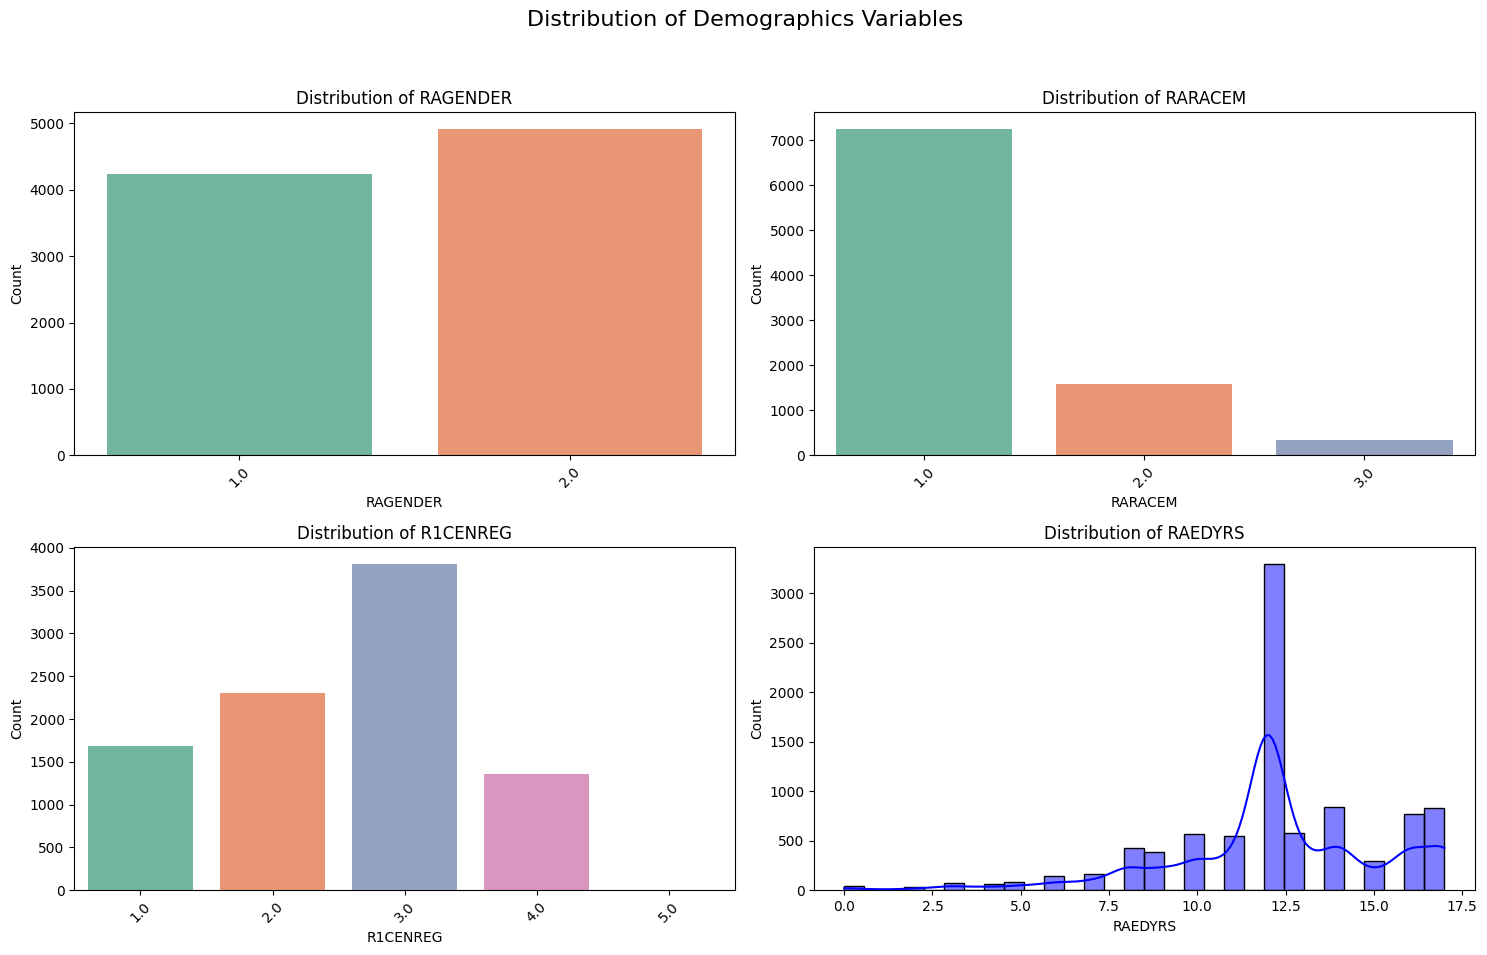

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of

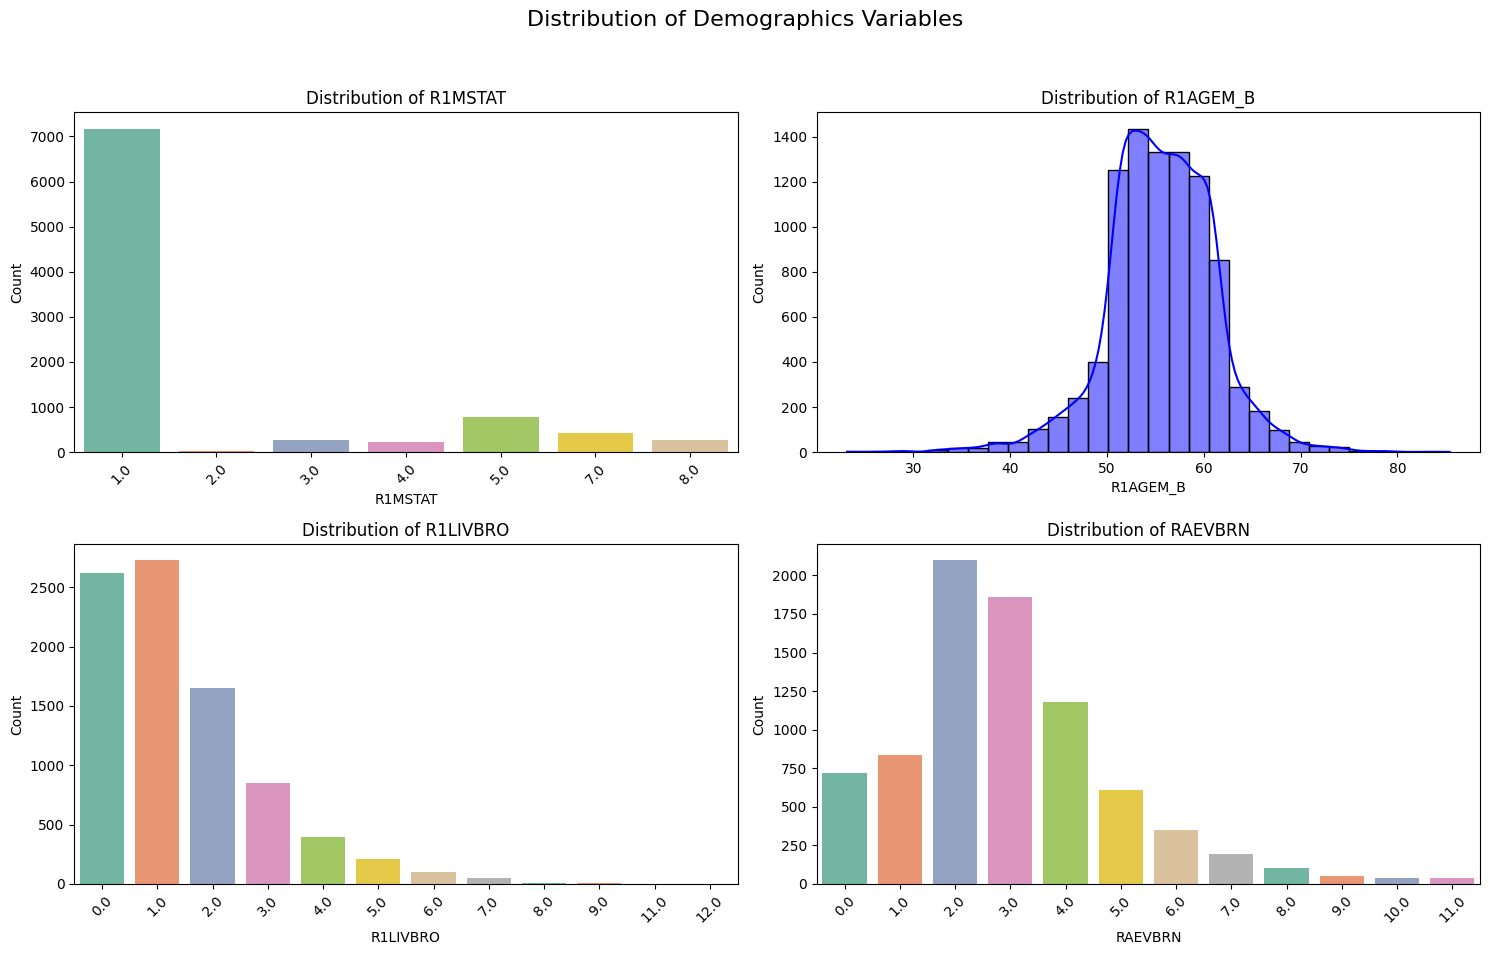

In [87]:
# Create 4 plots in the same figure
# Clear any existing figures to avoid overlap in Jupyter
plt.close('all')

# List of variables to plot (first 4 for 2x2 grid)
ngrid = 2
for page in range(0, ngrid):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Distribution of Demographics Variables", fontsize=16)

    plot_vars = demographics[page*4:(page*4 + 4)]
    for idx, col in enumerate(plot_vars):
        ax = axes[idx // 2, idx % 2]
        if col in ["R1AGEM_B", "RAEDYRS"]:
            sns.histplot(data=waveOneDemographics, x=col, bins=30, kde=True, color="blue", ax=ax)
        else:
            sns.countplot(data=waveOneDemographics, x=col, palette="Set2", ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Observations:  

**Gender**: there are more females than male  
**Race**: 3 levels; white caucasian take the majority, black take the second place.  
**Census Region**: most came from South Region, followed by Midwest; no one came from Other region  
**Education Years**: mode occur at 12-12.5 years of education (high school graduate or bachelor's degree); if set 12 years as water shed, more people had >12 years of education than people who don't  
**Current Maritial Status**: over 90% are married; the remaining are mostly partnered (probably not married yet, just lived together); around 1-2% are never married  and widowed  
**Number of Marriages**:  
**Age**: symmentrically distributed; mean and median occur around 55 years  
**Living Siblings**: most have only 0 or 1 living siblings; the number of people decrease with subling counts   
**Children Born**: over 50% people had 0-4 children in their lifetimes; mode occured at 3 children

## 3.2 Primary Variables of Interest

In [95]:
outcomeVars = [
    "R1TR40" # W1 TOTAL WORD RECALL SUMMARY SCORE
]
employmentVars = [
    "R1WORK", # W1 R working for pay
    "R1JHOURS", # W1 Hours worked/week main job
    "R1WGIHR", # W1 Imputed Wage Rate-Hrly
    "R1JCOCC", # W1 Current Job Occup/1980 Census
    "R1JPHYS", # W1 Cur job req lots phys effort Categ
    "R1JLIFT", # W1 Cur job req lift heavy loads
    "R1JSTRES", # W1 Cur job involves much stress
    "R1JSTOOP", # W1 Cur job req stoop/kneel/crouch
    "R1JSIGHT", # W1 Cur job req good eyesight
]

waveOneEmployment = waveOne[outcomeVars+employmentVars]
waveOneEmployment = pd.concat([waveOne["HHIDPN"], waveOneEmployment], axis=1)
waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave
print(waveOneEmployment.head())
print(waveOneEmployment.shape)
print(waveOneEmployment.info())
# print(waveOneEmployment.isna().sum())

       HHIDPN  R1TR40  R1WORK  R1JHOURS    R1WGIHR  R1JCOCC  R1JPHYS  R1JLIFT  \
0      1010.0    17.0     1.0      40.0  15.000000      7.0      3.0      4.0   
1      2010.0    19.0     0.0       NaN        NaN      NaN      NaN      NaN   
2      3010.0    11.0     1.0      40.0  22.000000     13.0      2.0      2.0   
3      3020.0    21.0     1.0      15.0   4.500000      3.0      2.0      3.0   
4  10001010.0     8.0     0.0       NaN   5.452073      NaN      NaN      NaN   

   R1JSTRES  R1JSTOOP  R1JSIGHT  
0       4.0       4.0       2.0  
1       NaN       NaN       NaN  
2       2.0       1.0       2.0  
3       3.0       3.0       2.0  
4       NaN       NaN       NaN  
(9158, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 9158 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HHIDPN    9158 non-null   float64
 1   R1TR40    8707 non-null   float64
 2   R1WORK    9146 non-null   float64
 

C:\Users\86139\AppData\Local\Temp\ipykernel_18452\2048724117.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave


C:\Users\86139\AppData\Local\Temp\ipykernel_18452\448522255.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=waveOneEmployment, x=col, y = outcomeVars[0], palette="Set2", ax=ax)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\86139\AppData\Local\Temp\ipykernel_18452\448522255.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\86139\AppData\Local\Temp\ipykernel_18452\448522255.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=waveOneEmployment, x=col, y = outcomeVars[0], palette="Set2", ax=ax)
C:\Users\86139\AppData\Local\Temp\ipykernel_1

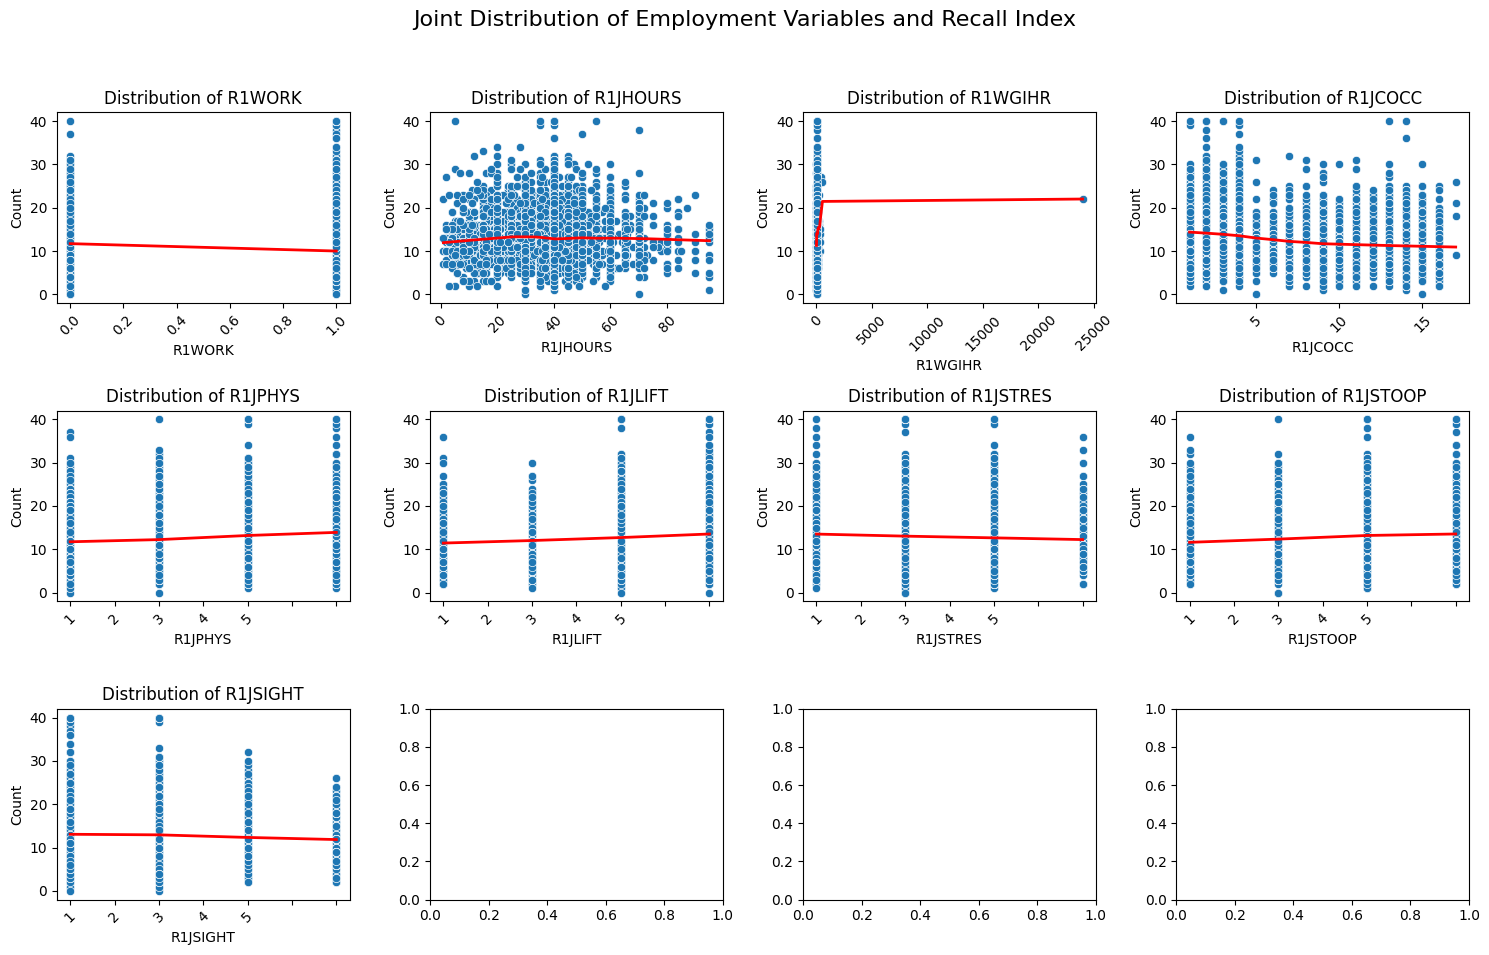

In [100]:
## Create scatter plot for R1TR40 and employment variables
# List of variables to plot (first 4 for 2x2 grid)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Joint Distribution of Employment Variables and Recall Index", fontsize=16)
plot_vars = employmentVars
for idx, col in enumerate(plot_vars):
    ax = axes[idx // 4, idx % 4]
    sns.scatterplot(data=waveOneEmployment, x=col, y = outcomeVars[0], palette="Set2", ax=ax)
    # Fit and plot a LOWESS (locally weighted scatterplot smoothing) line
    sns.regplot(
        data=waveOneEmployment,
        x=col,
        y=outcomeVars[0],
        scatter=False,
        lowess=True,
        line_kws={'color': 'red', 'lw': 2},
        ax=ax
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

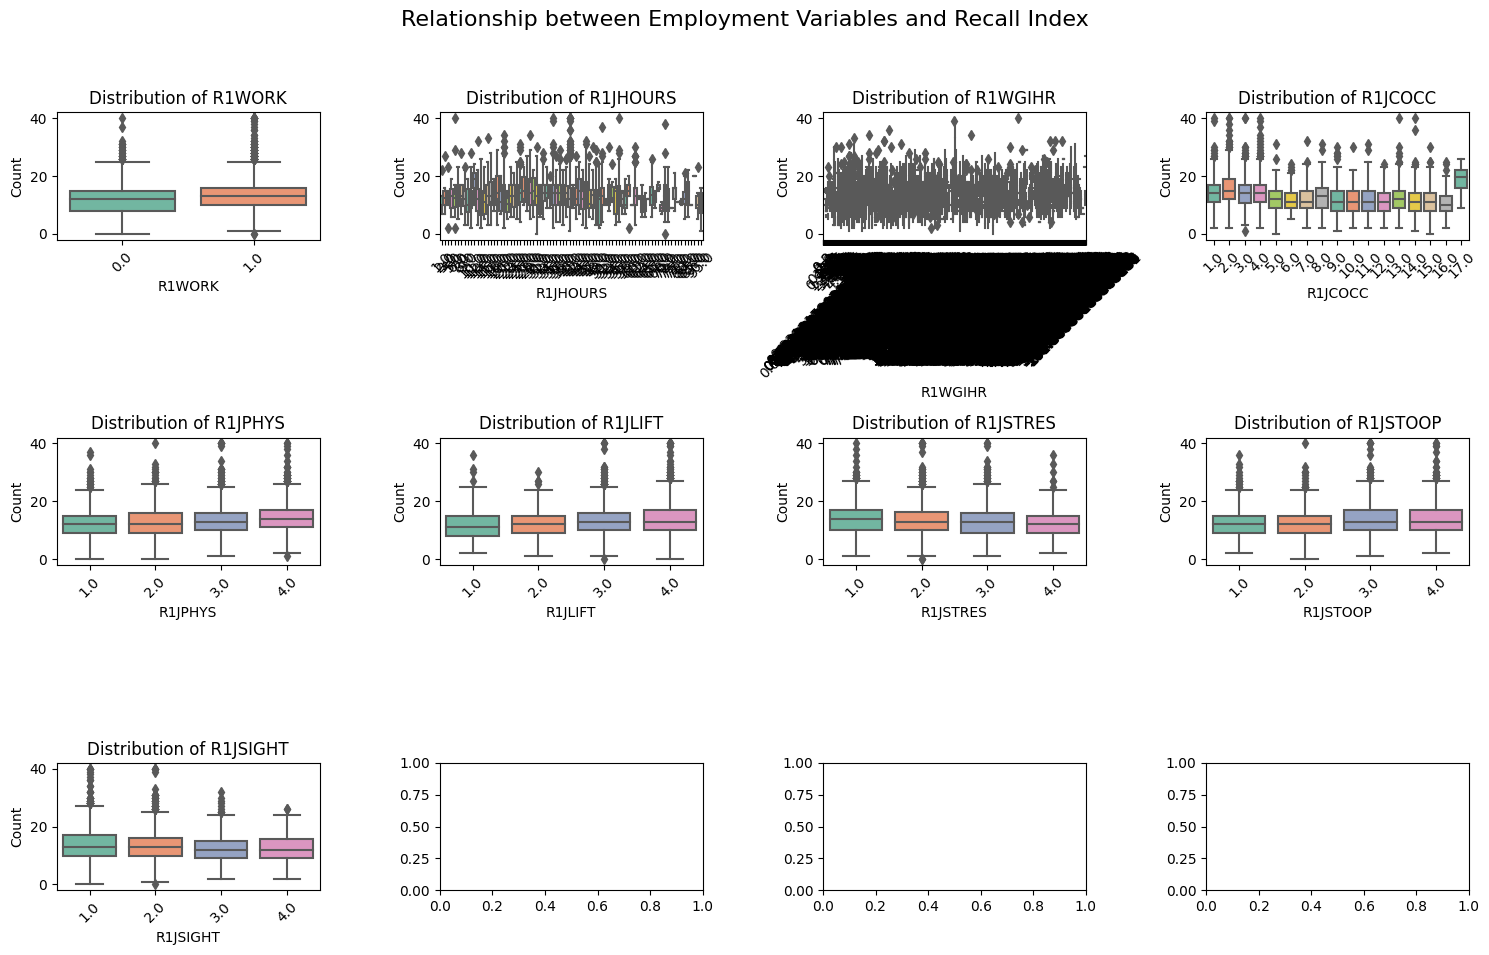

In [101]:
## Box Plot to inspect relationship between employment variables and recall index, with spread quantified

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Relationship between Employment Variables and Recall Index", fontsize=16)
plot_vars = employmentVars
for idx, col in enumerate(plot_vars):
    ax = axes[idx // 4, idx % 4]
    sns.boxplot(data=waveOneEmployment, x=col, y = outcomeVars[0], palette="Set2", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observations:  
A lot of variability in Recall Index exists even conditioned in employment status variables.
Weak association between recall index and employment metrics.

**Employment Status**: people who are working for pay have slighly higher recall index than who don't.  
**Occupation Catgeory**: members of armed forces have better recall index than the rest; professional specialty opr/tech, clerical/admin supp, precison production, and operators:machine tend to have top tier outliers.  
**Wage Rate**: very weak relationship  
**Work Hours**: very weak non-linear relationship   
**Phyical Effort**: recall index decrease as physical effort required increases.   
**Lifting**: same trend as phyical effort   
**Stress**: recall index increase with stress     
**Stoping, Kneeling**: recall index decrease with stooping, kneeling, etc   
**Eyesight**: recall index decrease with eyesight requirement  

## 3.3 Socioeconomic Variables

# 4. Correlation Analysis

# 5. Simple Regression Analysis

In [ ]:
def ols_fit(var,response_var='R5COG27', data = data):
    filtered_dropna = data.dropna(subset=[var ,response_var])
    X = filtered_dropna[[var]]  # 自变量（分类变量，字符串类型）
    y = filtered_dropna[response_var]    # 因变量（数值型，float）


    # 独热编码（将字符串分类变量转换为数值）
    X_encoded = pd.get_dummies(X, columns=[var], drop_first=True)

    # 强制转换为浮点型（避免布尔类型导致object错误）
    X_encoded = X_encoded.astype(float)

    # 添加截距项
    X_encoded = sm.add_constant(X_encoded, has_constant='add')


    # 拟合线性回归模型
    try:
        model = sm.OLS(y.astype(float), X_encoded.astype(float)).fit()
        print(model.summary())
    except Exception as e:
        print(f"错误信息: {str(e)}")
        print("排查建议:")
        print("1. 检查 X_encoded 是否存在全为常数的列（如所有样本属于同一类别）")
        print("2. 确保 y 中没有缺失值: y.isnull().sum() =", y.isnull().sum())
        print("3. 数据集filter正确", head(filtered_dropna))

In [6]:
# 认知能力 与 职业 的拟合
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'14.Operators: machine', '09.Personal svc', '10.Farming/forestry/fishing', '02.Prof specialty opr/tech sup', '17.Member of Armed Forces', '15.Operators: transport, etc', '16.Operators: handlers, etc', '13.Precision production', '11.Mechanics/repair', nan, '07.Svc:food prep', '12.Constr trade/extractors', '05.Svc:prv hhld/clean/bldg svc', '08.Health svc', '06.Svc:protection', '03.Sales', '01.Managerial specialty oper', '04.Clerical/admin supp'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     62.77
Date:                Tue, 20 May 2025   Prob (F-statistic):          8.42e-188
Time:                        10:56:10   Log-Likelihood:                -16909.
No. Observations:                6087   AIC:                         3.385e+0

In [20]:
# 认知能力 与 视力 的拟合
response_var= 'R5COG27'
var = 'R1JSIGHT'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'2.Most of the time', '4.None/almost none of time', '3.Some of the time', '1.All/almost all the time', nan}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.057
Date:                Tue, 20 May 2025   Prob (F-statistic):            0.00169
Time:                        14:00:07   Log-Likelihood:                -17274.
No. Observations:                6054   AIC:                         3.456e+04
Df Residuals:                    6050   BIC:                         3.458e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.97

In [22]:
# 认知能力 与 职业压力 的拟合
response_var= 'R5COG27'
var = 'R1JSTRES'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     13.81
Date:                Tue, 20 May 2025   Prob (F-statistic):           5.63e-09
Time:                        14:07:26   Log-Likelihood:                -17228.
No. Observations:                6043   AIC:                         3.446e+04
Df Residuals:                    6039   BIC:                         3.449e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
# 认知能力 与 职业 的拟合 condition on 视力 = ['4.None/almost none of time', '3.Some of the time']
response_var= 'R5COG27'
var = 'R1JCOCC'

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSIGHT'].isin(['4.None/almost none of time', '3.Some of the time'])  # 请根据实际数据调整具体值
]

ols_fit(var = var, response_var = response_var,data = tem_data)

                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     11.87
Date:                Tue, 20 May 2025   Prob (F-statistic):           3.83e-26
Time:                        13:50:51   Log-Likelihood:                -1894.9
No. Observations:                 673   AIC:                             3822.
Df Residuals:                     657   BIC:                             3894.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
# 认知能力 与 职业 的拟合 condition on 视力 = ['1.All/almost all the time', '2.Most of the time']
response_var= 'R5COG27'
var = 'R1JCOCC'

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSIGHT'].isin(['1.All/almost all the time'])  # 请根据实际数据调整具体值
]

ols_fit(var = var, response_var = response_var,data = tem_data)

                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     35.65
Date:                Tue, 20 May 2025   Prob (F-statistic):          7.72e-102
Time:                        13:57:10   Log-Likelihood:                -9068.8
No. Observations:                3274   AIC:                         1.817e+04
Df Residuals:                    3257   BIC:                         1.828e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [24]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['4.Strongly disagree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['4.Strongly disagree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.296
Date:                Tue, 20 May 2025   Prob (F-statistic):           4.83e-05
Time:                        14:09:14   Log-Likelihood:                -764.68
No. Observations:                 266   AIC:                             1561.
Df Residuals:                     250   BIC:                             1619.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['2.Agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['2.Agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     24.96
Date:                Tue, 20 May 2025   Prob (F-statistic):           2.72e-69
Time:                        14:10:59   Log-Likelihood:                -7111.2
No. Observations:                2565   AIC:                         1.426e+04
Df Residuals:                    2548   BIC:                         1.436e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [29]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['1.Strongly agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['1.Strongly agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     10.82
Date:                Tue, 20 May 2025   Prob (F-statistic):           2.61e-26
Time:                        14:12:22   Log-Likelihood:                -3285.5
No. Observations:                1192   AIC:                             6605.
Df Residuals:                    1175   BIC:                             6691.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [ ]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['1.Strongly agree', '2.Agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['1.Strongly agree', '2.Agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     35.56
Date:                Tue, 20 May 2025   Prob (F-statistic):          1.11e-102
Time:                        14:12:56   Log-Likelihood:                -10409.
No. Observations:                3757   AIC:                         2.085e+04
Df Residuals:                    3740   BIC:                         2.096e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------